# Project 08: Epidemium - Summary
## Bloc n°6 - Jedha - dsmft - Paris14
### Joseph Abitbol & Nicolas Hegerle

## Library import and function definition

### <ins>Import the required libraries</ins>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style = 'darkgrid')
import os
from graph_func import *
from IPython.display import clear_output

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### <ins>Function definition</ins>

In [3]:
def load_dfs(root_dir):

    #Instantiate a dataframe to be populated with all the predictions made over model training
    df_all_preds = pd.DataFrame()
    df_list = []
    # relative path to the folder containg all the subfolder and files of training prediction datas


    #Loop over all the folders containing all the predictions files 
    for pred_csv in os.listdir(f"{root_dir}"): # loop over the csv files in each subfolder
        if pred_csv[0] != '.':
            
            split_name = pred_csv.split(".")[0].split("_")  #split the name of the file to get the info we need to fill up the columns
            df_filename = pred_csv.split(".")[0] #get the filenam without the .csv extension to use with globals()
            #load the dataframe as an individual global variable to access it later
            df = pd.read_csv(os.path.join(root_dir, pred_csv)) # read the csv file into a dataframe
            globals()[df_filename] = df
            df_list.append(df_filename)

            # create new columns to be used later for plotting
            df['file_name'] = df_filename
            df['cell_type'] = split_name[0]
            df['img_format'] = split_name[1]
            df['model'] = '_'.join(split_name[2:4])
            df['img_set'] = split_name[-1]
            

            
            # concatenate all the datafames together
            df_all_preds = pd.concat([df_all_preds, df], ignore_index=True)

    train_dfs = [globals()[df] for df in sorted(df_list) if df.split('_')[-1] == 'train']
    test_dfs = [globals()[df] for df in sorted(df_list) if df.split('_')[-1] == 'test']

    row_names = []
    for item in sorted(df_list):
        item = '_'.join(item.split('_')[:-1])
        if item in row_names:
            continue
        else:
            row_names.append(item)
    
    return train_dfs, test_dfs, row_names

## Dummy model mae for the ```mean model```, ```median model``` and ```random model``` for baseline purposes

In [4]:
#load the train data for verification
data = pd.read_csv("raw_data/avatarsV2_train.csv", parse_dates=[3,4,6])
data.rename(columns = {col:col.lower().replace(' ', '_') for col in data.columns}, inplace = True)

#n supposed to be between 0 and 3 but have 2a, 2b, 2c => lets consider it all 2 for now
data['n'] = data['n'].apply(lambda x : 2 if x in ["2a", "2b", "2c"] else x)
data = data.astype({'n': 'int64'})

#columns to drop: no_info => patient_id & localisation. Highly correlated => age, date_biopsie, date_dernieres_nouvelles, alcool => a single non drinking patient
cols_to_drop = ["id", "localisation", "ddn", "date_biopsie", "data"]
to_keep = [col for col in data.columns if col not in cols_to_drop]
data = data[to_keep]
display(data.head())

# split the data in X and y
y = data['os'].values
X = data[[col for col in data.columns if col != 'os']].values

# instantiate the dummy regressors
dr_mean = DummyRegressor(strategy = 'mean')
dr_median = DummyRegressor(strategy = 'median')

# fit the models to the data
dr_mean.fit(X, y)
dr_median.fit(X, y)

# get the scores for those dummy models
print("Mean Absolute Error for dummy model predicting mean: " ,mean_absolute_error(y, dr_mean.predict(X)))
print("Mean Squared Error for dummy model predicting mean: " ,mean_squared_error(y, dr_mean.predict(X)))
print("R2 score for dummy model predicting mean: " ,r2_score(y, dr_mean.predict(X)))
dummy_mae = mean_absolute_error(y, dr_mean.predict(X))

print("\nMean Absolute Error for dummy model predicting median: ", mean_absolute_error(y, dr_median.predict(X)))
print("Mean Squarred Error for dummy model predicting median: ", mean_squared_error(y, dr_median.predict(X)))
print("R2 score for dummy model predicting median: " ,r2_score(y, dr_median.predict(X)))

# lets see what a random prediction does
scores = {'mae': [], 'mse': [], 'r2': []}
for i in range(101):

    y_rand_pred = np.random.randint(y.min(), y.max(), len(y))
    mae = mean_absolute_error(y, y_rand_pred)
    mse = mean_squared_error(y, y_rand_pred)
    r2 = r2_score(y, y_rand_pred)

    scores['mae'].append(mae)
    scores['mse'].append(mse)
    scores['r2'].append(r2)

print(f"\nMean Absolute Error for randaom predictions: {round(np.mean(scores['mae']), 3)}, std = {round(np.std(scores['mae']), 3)}")
print(f"Mean Squarred Error ffor randaom predictions: {round(np.mean(scores['mse']), 3)}, std = {round(np.std(scores['mse']), 3)}")
print(f"R2 score for for randaom predictions: {round(np.mean(scores['r2']), 3)}, std = {round(np.std(scores['r2']), 3)}")


,oms,sexe_(0=f_1=m),age_au_diag,deces_code,code_recidive,rnascope,t,n,m,tabac,alcool,os
0,1,1,59,0,0,2,4,2,0,3,1,84
1,1,1,77,1,0,1,4,2,1,2,1,24
2,1,1,44,0,0,2,3,3,0,3,1,47
3,1,1,67,1,0,1,2,2,0,2,1,9
4,1,1,71,0,1,1,4,2,1,2,0,37


Mean Absolute Error for dummy model predicting mean:  19.73076923076923
Mean Squared Error for dummy model predicting mean:  528.3798076923077
R2 score for dummy model predicting mean:  0.0

Mean Absolute Error for dummy model predicting median:  19.442307692307693
Mean Squarred Error for dummy model predicting median:  555.9423076923077
R2 score for dummy model predicting median:  -0.05216418114155208

Mean Absolute Error for randaom predictions: 27.739, std = 2.448
Mean Squarred Error ffor randaom predictions: 1143.65, std = 158.255
R2 score for for randaom predictions: -1.164, std = 0.3


## Determine best model based on Mean Absolute Error (mae)

### <ins>Load all models and compute best mae</ins>

In [5]:
#Instantiate a dataframe to be populated with all the predictions made over model training
df_all_preds = pd.DataFrame()
df_list = []
# relative path to the folder containg all the subfolder and files of training prediction datas
top_dir = "src/pred_df" 

#Loop over all the folders containing all the predictions files 
for dir_path in os.listdir(top_dir):
    if dir_path[0]!= '.': # make sure to avoid any filename starting with '.'
        for pred_csv in os.listdir(f"{top_dir}/{dir_path}"): # loop over the csv files in each subfolder
            if pred_csv[0] != '.':
                
                split_name = pred_csv.split(".")[0].split("_")  #split the name of the file to get the info we need to fill up the columns
                df_filename = pred_csv.split(".")[0] #get the filenam without the .csv extension to use with globals()
                #load the dataframe as an individual global variable to access it later
                globals()[df_filename] = pd.read_csv(f"{top_dir}/{dir_path}/{pred_csv}")
                df_list.append(df_filename)

                df = pd.read_csv(f"{top_dir}/{dir_path}/{pred_csv}") # read the csv file into a dataframe




                # create new columns to be used later for plotting
                df['file_name'] = df_filename
                df['cell_type'] = split_name[0]
                df['model'] = split_name[1]
                df['img_set'] = split_name[-1]

                if ('3who' in split_name) or ('liimatainen' in split_name):
                    df['3who'] = 1
                else:
                    df['3who'] = 0

                if 'mse' in split_name:
                    df['loss'] = 'mse'
                else:
                    df['loss'] = 'mae'

                if 'liimatainen' in split_name:
                    df['trainable'] = 'base'
                else:
                    df['trainable'] = split_name[2]
                

                
                # concatenate all the datafames together
                df_all_preds = pd.concat([df_all_preds, df], ignore_index=True)

# lets check if it seems coherent
print("Shape of the dataframe: ", df_all_preds.shape)
print("\nHead of the dataframe:")
display(df_all_preds.head())
            

Shape of the dataframe:  (773459, 11)

Head of the dataframe:


,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable
0,67,55,12,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3
1,67,68,1,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3
2,67,75,8,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3
3,67,60,7,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3
4,67,49,18,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3


In [6]:

print("\nSome info on the dataframe:")
display(df_all_preds.describe(include = 'all'))


Some info on the dataframe:


,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable
count,773459.000000,773459.000000,773459.000000,773459.000000,773459,773459,773459,773459,773459.0,773459,773459
unique,NaN,NaN,NaN,NaN,350,7,4,2,NaN,1,4
top,NaN,NaN,NaN,NaN,all_rrb_CN_base_train,all,rrb,train,NaN,mae,Iv3
freq,NaN,NaN,NaN,NaN,3200,127900,221804,393091,NaN,773459,208318
mean,49.966099,146.309772,128.795182,50.076376,NaN,NaN,NaN,NaN,0.0,NaN,NaN
std,22.215660,5022.100622,5021.567335,22.111288,NaN,NaN,NaN,NaN,0.0,NaN,NaN
min,0.000000,-54730.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
25%,31.000000,37.000000,6.000000,34.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
50%,55.000000,51.000000,14.000000,55.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
75%,67.000000,60.000000,27.000000,67.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [7]:
df_stats = df_all_preds
df_stats['x_label'] = df_stats['file_name'].apply(lambda x : ('_').join(x.split('_')[0:4]))
display(df_stats.head())
df_stats.shape

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,67,55,12,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
1,67,68,1,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
2,67,75,8,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
3,67,60,7,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
4,67,49,18,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base


(773459, 12)

In [8]:
df_all_train = df_stats[df_stats['img_set'] == "train"]
df_all_train.reset_index(drop=True, inplace=True)
display(df_all_train.head())
df_all_train.shape

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,21,121,100,21,ci4_red_Iv3_base_train,ci4,red,train,0,mae,Iv3,ci4_red_Iv3_base
1,21,25,4,21,ci4_red_Iv3_base_train,ci4,red,train,0,mae,Iv3,ci4_red_Iv3_base
2,21,24,3,21,ci4_red_Iv3_base_train,ci4,red,train,0,mae,Iv3,ci4_red_Iv3_base
3,21,15,6,21,ci4_red_Iv3_base_train,ci4,red,train,0,mae,Iv3,ci4_red_Iv3_base
4,21,25,4,21,ci4_red_Iv3_base_train,ci4,red,train,0,mae,Iv3,ci4_red_Iv3_base


(393091, 12)

In [9]:
# number of top models to keep based on their mae
n_top = 20

# calculate the minimum mae
train_mae_stat = df_all_train.groupby(by = 'file_name', as_index = False)['abs_error'].agg(['mean', 'std']) # calculate mean and std of mae for all trained models
train_mae_stat.reset_index(inplace = True)
max_train_mae = train_mae_stat['mean'].sort_values(ascending = True)[ :n_top].max() # get the max mae out of the top 10 lowest mae
min_train_mae = train_mae_stat['mean'].min() # get the minimum mae
mask = train_mae_stat['mean'] <= max_train_mae # generate mask to keep only the top 10 mae for the train set

# keep only data for the top models based on their mae
train_mae_stat = train_mae_stat.loc[mask]
train_mae_stat['x_label'] = train_mae_stat['file_name'].apply(lambda x : ('_').join(x.split('_')[0:4]))
train_mae_stat.sort_values(by = 'mean', ascending = True, inplace = True)
train_mae_stat.reset_index(drop= True, inplace = True)

# filter the train dataframe to keep only data for the top models
rows_to_keep = train_mae_stat['file_name']
df_all_train = df_all_train[df_all_train['file_name'].isin(rows_to_keep)]

display(train_mae_stat)
train_mae_stat.shape

,file_name,mean,std,x_label
0,cti5_rrb_Iv3_20pct_train,4.590421,4.913594,cti5_rrb_Iv3_20pct
1,all_raw_Iv3_20pct_train,4.855251,4.761613,all_raw_Iv3_20pct
2,cti5_red_Iv3_20pct_train,5.641013,4.600535,cti5_red_Iv3_20pct
3,all_raw_IRNv2_20pct_train,5.708676,6.873993,all_raw_IRNv2_20pct
4,ci2_rrb_Iv3_20pct_train,6.141898,5.964818,ci2_rrb_Iv3_20pct
5,cti5_rrb_DN201_20pct_train,6.236795,5.355091,cti5_rrb_DN201_20pct
6,all_rrb_IRNv2_20pct_train,6.269196,7.317305,all_rrb_IRNv2_20pct
7,all_red_Iv3_20pct_train,6.278799,6.498796,all_red_Iv3_20pct
8,ci4_rrb_Iv3_20pct_train,6.358997,5.247655,ci4_rrb_Iv3_20pct
9,all_rrb_Iv3_20pct_train,6.419643,6.802304,all_rrb_Iv3_20pct


(20, 4)

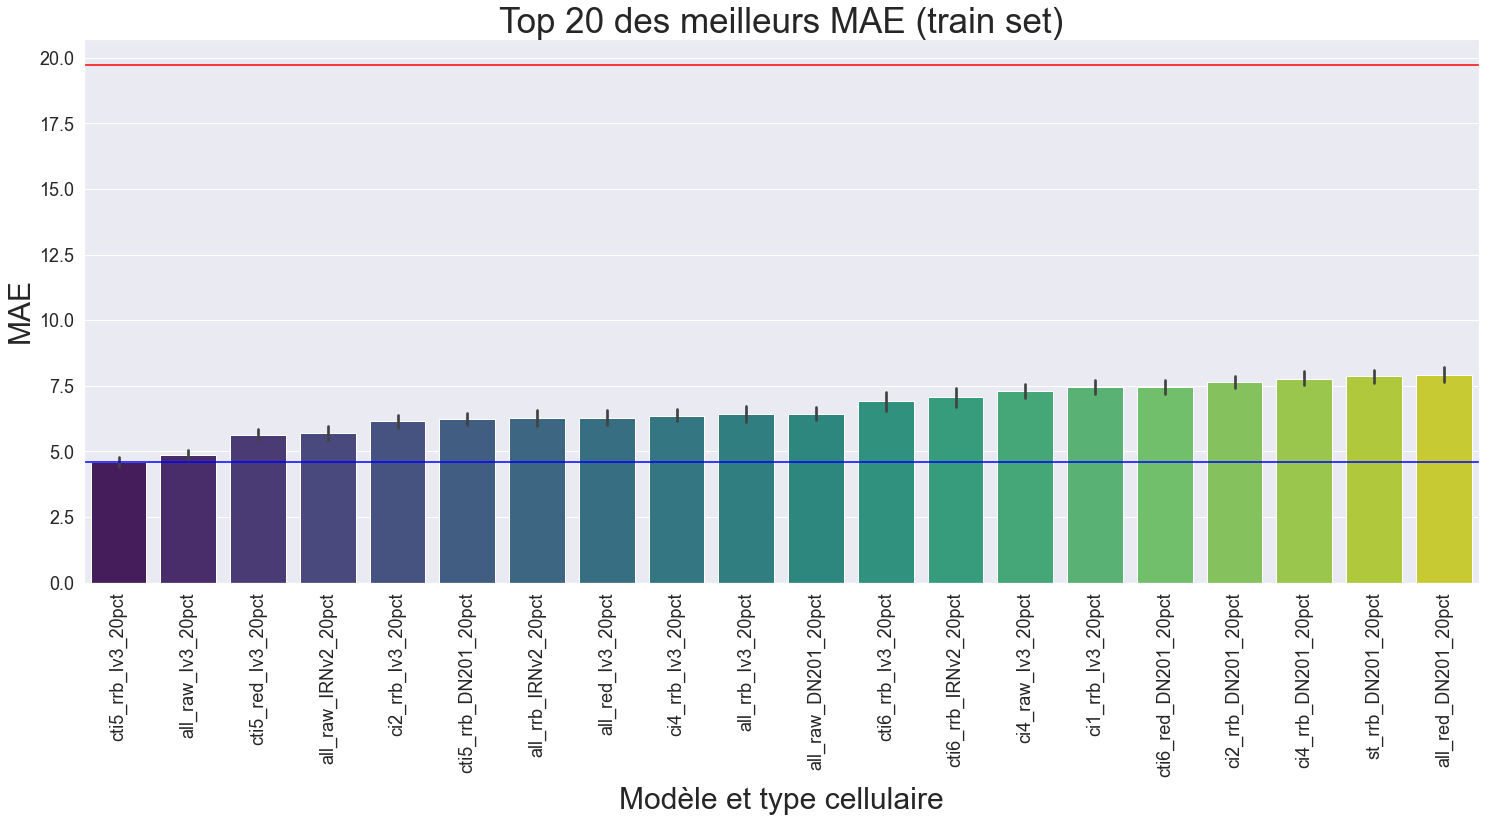

In [10]:
order = [x for x in train_mae_stat['x_label']] # order for plotting the bars

plt.figure(figsize = (25, 10))
plt.xticks(rotation=90)

b = sns.barplot(data = df_all_train, x = 'x_label', y = 'abs_error', palette = 'viridis', order = order)
plt.axhline(dummy_mae, color = 'red')
plt.axhline(min_train_mae, color = 'blue')

b.axes.set_title(f"Top {n_top} des meilleurs MAE (train set)",fontsize=35)
b.set_xlabel("Modèle et type cellulaire",fontsize=30, labelpad = 10)
b.set_ylabel("MAE",fontsize=30)
b.tick_params(labelsize=18)
plt.show()

In [11]:
df_all_val = df_stats[df_stats['img_set'] == "test"]
df_all_val.reset_index(drop=True, inplace=True)
df_all_val.head()

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,67,55,12,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
1,67,68,1,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
2,67,75,8,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
3,67,60,7,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base
4,67,49,18,67,all_blue_Iv3_base_test,all,blue,test,0,mae,Iv3,all_blue_Iv3_base


In [12]:
# calculate the minimum mae
val_mae_stat = df_all_val.groupby(by = 'file_name', as_index = False)['abs_error'].agg(['mean', 'std'])
val_mae_stat.reset_index(inplace = True)
max_val_mae = val_mae_stat['mean'].sort_values(ascending = True)[ :n_top].max()
min_val_mae = val_mae_stat['mean'].min()
mask = val_mae_stat['mean'] <= max_val_mae

# keep only data for the top models based on their mae
val_mae_stat = val_mae_stat.loc[mask]
val_mae_stat['x_label'] = val_mae_stat['file_name'].apply(lambda x : ('_').join(x.split('_')[0:4]))
val_mae_stat.sort_values(by = 'mean', ascending = True, inplace = True)
val_mae_stat.reset_index(drop = True, inplace = True)

# filter the validation dataframe to keep only data for the top models
rows_to_keep = val_mae_stat['file_name']
df_all_val = df_all_val[df_all_val['file_name'].isin(rows_to_keep)]


display(val_mae_stat)
val_mae_stat.shape


,file_name,mean,std,x_label
0,all_rrb_IRNv2_20pct_test,12.514760,12.801446,all_rrb_IRNv2_20pct
1,all_raw_Iv3_20pct_test,12.644942,11.674140,all_raw_Iv3_20pct
2,all_rrb_Iv3_20pct_test,13.012915,11.788899,all_rrb_Iv3_20pct
3,all_raw_IRNv2_20pct_test,13.099708,12.151528,all_raw_IRNv2_20pct
4,cti6_rrb_Iv3_20pct_test,13.298332,12.233624,cti6_rrb_Iv3_20pct
5,all_red_Iv3_20pct_test,13.328627,12.100633,all_red_Iv3_20pct
6,cti6_rrb_IRNv2_20pct_test,13.379784,12.101113,cti6_rrb_IRNv2_20pct
7,all_red_IRNv2_20pct_test,13.474197,12.012214,all_red_IRNv2_20pct
8,all_raw_DN201_20pct_test,13.594358,12.566818,all_raw_DN201_20pct
9,all_rrb_DN201_20pct_test,14.024908,11.425137,all_rrb_DN201_20pct


(20, 4)

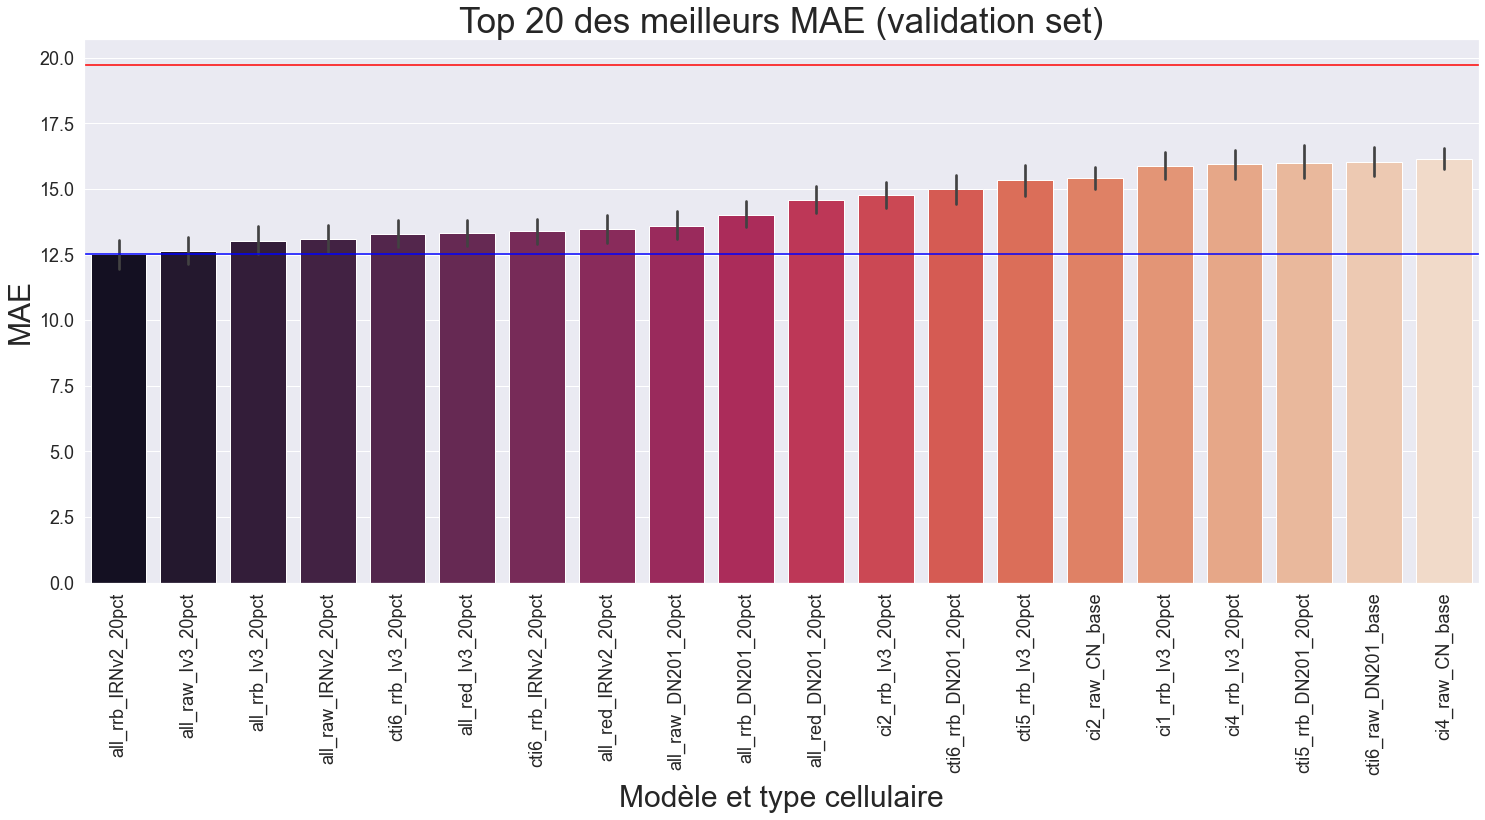

In [13]:
order = [x for x in val_mae_stat['x_label']]

plt.figure(figsize = (25, 10))
plt.xticks(rotation=90)

b = sns.barplot(data = df_all_val, x = 'x_label', y = 'abs_error', palette = 'rocket', order = order)
plt.axhline(dummy_mae, color = 'red')
plt.axhline(min_val_mae, color = 'blue')

b.axes.set_title(f"Top {n_top} des meilleurs MAE (validation set)",fontsize=35)
b.set_xlabel("Modèle et type cellulaire",fontsize=30, labelpad = 10)
b.set_ylabel("MAE",fontsize=30)
b.tick_params(labelsize=18)
plt.show()

### <ins>Plot lineplot of the train and val sets for the best model based on validation mae</ins>

In [14]:
df_irnv2_train = pd.read_csv("src/pred_df/IRNv2_20pct_preds/all_rrb_IRNv2_20pct_train.csv")
df_irnv2_val = pd.read_csv("src/pred_df/IRNv2_20pct_preds/all_rrb_IRNv2_20pct_test.csv")

df_irnv2_train['set'] = 'train'
df_irnv2_val['set'] = 'test'
df_all_irnv2 = pd.concat([df_irnv2_train, df_irnv2_val])
df_all_irnv2.reset_index(drop=True, inplace = True)

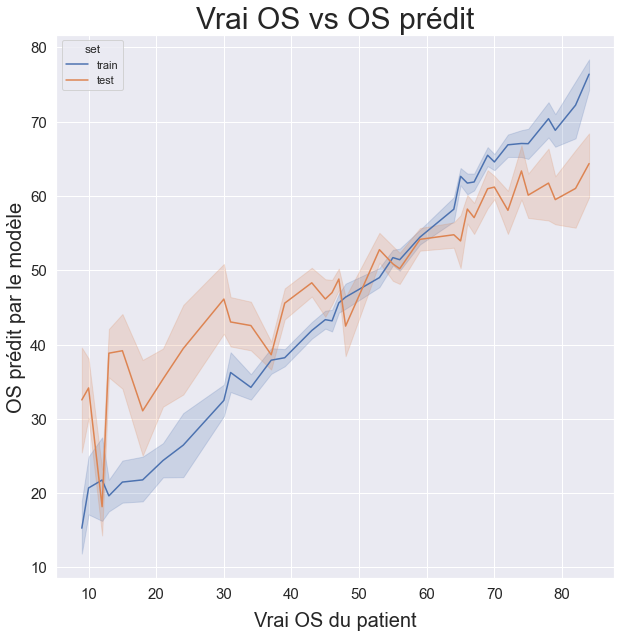

In [15]:
plt.figure(figsize = (10, 10))
plt.xticks(rotation=0)

b = sns.lineplot(data = df_all_irnv2, x = 'true', y = 'pred', hue='set')

b.axes.set_title("Vrai OS vs OS prédit",fontsize=30)
b.set_xlabel("Vrai OS du patient",fontsize=20, labelpad = 10)
b.set_ylabel("OS prédit par le modèle",fontsize=20)
b.tick_params(labelsize=15)
plt.show()

### <ins>Plot summary graphs for best model</ins>

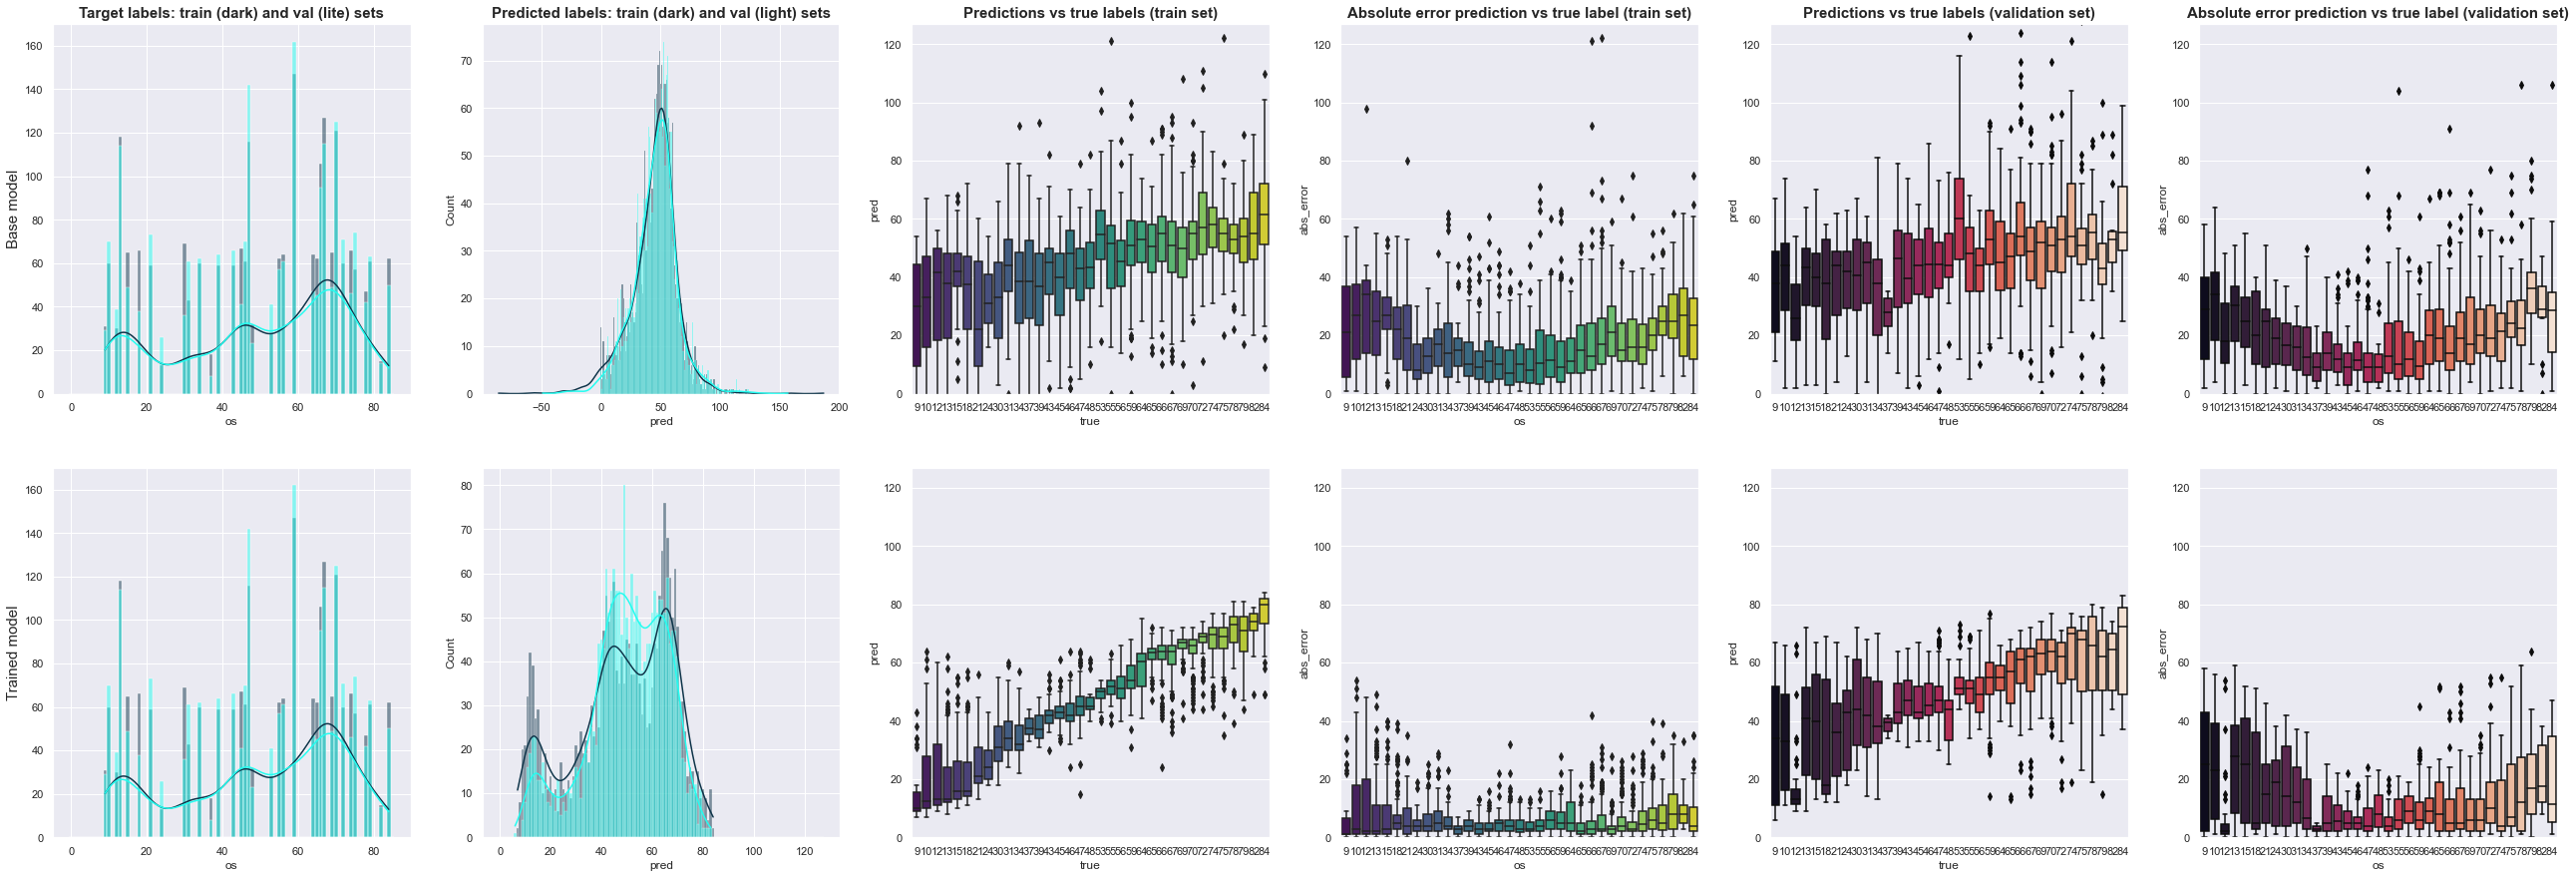

In [16]:
df_irnv2_base_train = pd.read_csv("src/pred_df/IRNv2_base_preds/all_rrb_IRNv2_base_train.csv")
df_irnv2_base_val = pd.read_csv("src/pred_df/IRNv2_base_preds/all_rrb_IRNv2_base_test.csv")
df_irnv2_train = pd.read_csv("src/pred_df/IRNv2_20pct_preds/all_rrb_IRNv2_20pct_train.csv")
df_irnv2_val = pd.read_csv("src/pred_df/IRNv2_20pct_preds/all_rrb_IRNv2_20pct_test.csv")
df_all = pd.read_csv("src/train/train_img_data.csv")

# Effect of training on model predictions
fig, ax = plot_summary_stats([df_irnv2_base_train, df_irnv2_train], [df_irnv2_base_val, df_irnv2_val], ["Base model", "Trained model"], width = 45, height = 15)
plt.show()

In [17]:
# target stats (os)
data['os'].describe()

count    52.000000
mean     50.250000
std      23.210778
min       6.000000
25%      33.250000
50%      55.500000
75%      68.250000
max      89.000000
Name: os, dtype: float64

## Print summary graphs for all trained models

In [ ]:
root = "src/pred_df"
save_dir = "png/"
dirs = sorted([os.path.join(root, dir) for dir in os.listdir(root) if dir[0] != '.'])
print("====Directories to plot:====")
print(dirs)
plotted = []

for dir in dirs:
    print(f"Plotted graphs for: {plotted}")
    print(f"\n====Started plotting {dir}====")
    train, test, rows = load_dfs(dir)
    fig, ax = plot_summary_stats(train, test, rows, width = 40, height = 80)
    plt.savefig(os.path.join(save_dir, f"{dir.split('/')[-1]}_summary_graph.png"), dpi = 300)
    plt.clf()
    print(f"\n====Finished plotting {dir}====")
    plotted.append(dir)
    clear_output(wait = True)


In [ ]:
# root directory to look for predictions
root_dir = "src/pred_df"
sub_dirs = [dir for dir in os.listdir(root_dir) if dir[0]!='.']

# root directory where graphs will be saved
root_save_dir = "src/pred_graphs"

# dataframe with all the data
df_all = pd.read_csv("src/train/train_img_data.csv", index_col = 0)

# correspondance
cell_types = {
    'all' : None,
    'ci1' : 'cell_infla_1',
    'ci2' : 'cell_infla_2',
    'ci4' : 'cell_infla_4',
    'cti5' : 'cell_tum_infla_5',
    'cti6' : 'cell_tum_infla_6',
    'st' : 'seg_tissu'
}

for dir in sub_dirs:

    # list of unique model predictions
    files = set(['_'.join(x.split('_')[0:4]) for x in os.listdir(os.path.join(root_dir, dir)) if x[0]!='.'])
    
    # path to the directory where graphs will be saved
    save_dir = os.path.join(root_save_dir, dir)

    # create model subdirectory if it does not exist
    if os.path.exists(save_dir):
        print("===Directory exists===")
    else:
        os.mkdir(save_dir)

    for file in files:

        # load train and validation predictions
        df_train = pd.read_csv(f"{os.path.join(root_dir, dir, file)}_train.csv")
        df_val = pd.read_csv(f"{os.path.join(root_dir, dir, file)}_test.csv")

        # path where the graph is saved
        save_path = os.path.join(root_save_dir, dir, f"{file}_summary_graph.png")

        # plot the summary graph, save the image and clear the data
        cell_type = cell_types[file.split('_')[0]]
        fig, ax = plot_summary_graphs(df_all, df_train, df_val, cell_type = cell_type)
        plt.savefig(save_path, dpi = 300)
        plt.clf()

        print(f"====Finished plotting for {dir}, {file}, {cell_type}====")
    clear_output(wait = True)


